In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('..'))

import time
import torch
import random
import pickle
import datetime
import numpy as np
import custom_marl_aquarium
from models.ModularNetworks import PairwiseInteraction, Attention
from utils.es_utils_testing import *
from models.Buffer import Buffer
from models.PreyOnlyPolicy import PreyOnlyPolicy
from models.Discriminator import Discriminator

from utils.couzin_utils import *
from utils.sim_utils import *
mpl.use('TkAgg')
import math
import scipy.stats
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
from multiprocessing import Pool, set_start_method
from utils.train_utils import compute_wasserstein_loss, gradient_penalty

### Data Format & Output

In [5]:
expert_prey_batch = expert_buffer.sample(32)
policy_prey_batch = generative_buffer.sample(32)
print("expert_prey_batch", expert_prey_batch.shape)
print("policy_prey_batch", policy_prey_batch.shape)

dis_test = prey_discriminator.forward(expert_prey_batch) 
print( "Discriminator Output:", dis_test) 
print("Shape:", dis_test.shape)

prey_states = expert_prey_batch[..., :4] 
print("prey_states", prey_states.shape)

pol_test = prey_policy.forward(prey_states) 
print( "Policy Output:", pol_test)
print("Shape:", pol_test.shape)

expert_prey_batch torch.Size([32, 31, 5])
policy_prey_batch torch.Size([32, 31, 5])
Discriminator Output: tensor([-0.0715, -0.0456, -0.0425, -0.0801, -0.0582, -0.0373, -0.0471, -0.0746,
        -0.0729,  0.0034, -0.1219, -0.0987, -0.0883, -0.0830, -0.0124, -0.0455,
        -0.0489, -0.1178, -0.0736, -0.0645, -0.0901, -0.0311, -0.0846, -0.0164,
        -0.0521, -0.0776, -0.0434, -0.0301, -0.0865, -0.0797, -0.0503, -0.0838],
       grad_fn=<ViewBackward0>)
Shape: torch.Size([32])
prey_states torch.Size([32, 31, 4])
Policy Output: tensor([0.4970, 0.4956, 0.4947, 0.4959, 0.4961, 0.4966, 0.4969, 0.4963, 0.4949,
        0.4932, 0.4971, 0.4964, 0.4971, 0.4958, 0.4966, 0.4988, 0.4945, 0.4955,
        0.4966, 0.4980, 0.4933, 0.4960, 0.4993, 0.4925, 0.4951, 0.4969, 0.4950,
        0.4959, 0.4940, 0.4956, 0.4950, 0.4957], grad_fn=<SumBackward1>)
Shape: torch.Size([32])


### Discriminator Learnability

In [6]:
for i in range(10):
    expert_prey_batch = expert_buffer.sample(32)
    gen_prey_batch = generative_buffer.sample(32)
    gen_prey_batch[..., 4] = 0.0 # zero actions for testing

    dis_metric_prey = prey_discriminator.update(expert_prey_batch, gen_prey_batch, optim_dis_prey, lambda_gp_prey)

    print("\n [GEN {}] Wasserstein Loss: {:.4f}, Grad Penalty: {:.4f}, Expert Scores: {:.4f}, Policy Scores: {:.4f}".format(i, dis_metric_prey[0], dis_metric_prey[2], dis_metric_prey[3], dis_metric_prey[4]))


 [GEN 0] Wasserstein Loss: -0.0021, Grad Penalty: 0.8406, Expert Scores: -0.0518, Policy Scores: -0.0539

 [GEN 1] Wasserstein Loss: -8.3672, Grad Penalty: 9.4848, Expert Scores: 7.6357, Policy Scores: -0.7316

 [GEN 2] Wasserstein Loss: 2.7603, Grad Penalty: 0.7188, Expert Scores: -3.3752, Policy Scores: -0.6149

 [GEN 3] Wasserstein Loss: -1.6838, Grad Penalty: 0.2753, Expert Scores: 0.9067, Policy Scores: -0.7771

 [GEN 4] Wasserstein Loss: -4.8261, Grad Penalty: 2.5324, Expert Scores: 4.1912, Policy Scores: -0.6349

 [GEN 5] Wasserstein Loss: -2.9758, Grad Penalty: 0.0700, Expert Scores: 2.9127, Policy Scores: -0.0631

 [GEN 6] Wasserstein Loss: -9.1293, Grad Penalty: 10.0241, Expert Scores: 9.4091, Policy Scores: 0.2798

 [GEN 7] Wasserstein Loss: -0.7865, Grad Penalty: 0.3125, Expert Scores: 0.7267, Policy Scores: -0.0598

 [GEN 8] Wasserstein Loss: -2.0839, Grad Penalty: 0.0225, Expert Scores: 2.1394, Policy Scores: 0.0555

 [GEN 9] Wasserstein Loss: -4.7833, Grad Penalty: 0.53

### Evolutionary Strategy Optimization

Very plain setup for ES testing.
- plain network structure
- easy objective

In [7]:
def simulate_rollouts(policy, tensor):
    states = tensor[..., :4]
    actions = policy.forward(states)
    gen_states = torch.cat([states, actions], dim=-1)
    return gen_states


def f_target(states):
    dx  = states[:, 0]
    rvx = states[:, 2]
    return torch.sigmoid(12 * dx + 4 * rvx).view(-1, 1)


def fake_reward(gen_states):
    states = gen_states[:, :4]
    a_star = f_target(states) 
    a_pred = gen_states[:, 4:5]
    mse = (a_pred - a_star).pow(2).mean()
    return -mse #es maximizes


def gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations):
    grad = torch.zeros_like(theta)
    for eps, reward in zip(epsilons, rewards_norm):
        grad += eps * reward
    theta_est = theta + (lr / (2 * sigma**2 * num_perturbations)) * grad
    return theta_est


def optimize_es(policy, lr, sigma, num_perturbations, states):
    
    theta = nn.utils.parameters_to_vector(policy.parameters()).detach().clone()
    dim = theta.numel()

    reward_diffs = []
    epsilons = []

    for perturbation in range(num_perturbations):
        eps = torch.randn(dim, device=theta.device) * sigma
        epsilons.append(eps)

        nn.utils.vector_to_parameters(theta + eps, policy.parameters())
        pos_states = simulate_rollouts(policy, states)
        pos_reward = fake_reward(pos_states)

        nn.utils.vector_to_parameters(theta - eps, policy.parameters())
        neg_states = simulate_rollouts(policy, states)
        neg_reward = fake_reward(neg_states)

        nn.utils.vector_to_parameters(theta, policy.parameters())

        reward_diffs.append((pos_reward - neg_reward).detach())

    diffs = torch.stack(reward_diffs)
    rewards_norm = (diffs - diffs.mean()) / (diffs.std(unbiased=False) + 1e-8)

    theta_est = gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations)

    nn.utils.vector_to_parameters(theta_est, policy.parameters())

    return {
        "diff_min": round(diffs.min().item(), 3),
        "diff_max": round(diffs.max().item(), 3),
        "diff_mean": round(diffs.mean().item(), 3),
        "diff_std": round(diffs.std(unbiased=False).item(), 3),
        "delta_norm": round((theta_est - theta).norm().item(), 3),
        "reward": round(fake_reward(simulate_rollouts(policy, states)).item(), 3),
    }

In [ ]:
class SimpleNetwork(nn.Module):
    def __init__(self, dim=4, hidden=8):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden)
        self.fc2 = nn.Linear(hidden, 1)

    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        return torch.sigmoid(self.fc2(x))
    
policy = SimpleNetwork()
states = torch.randn(256, 4)

for generation in range(10):
    metrics = optimize_es(policy, lr=0.1, sigma=0.1, num_perturbations=30, states=states)
    print(f"Generation {generation}, Metrics: {metrics}")

Generation 0, Metrics: {'diff_min': -0.078, 'diff_max': 0.048, 'diff_mean': -0.008, 'diff_std': 0.033, 'delta_norm': 0.874, 'reward': -0.16}
Generation 1, Metrics: {'diff_min': -0.037, 'diff_max': 0.034, 'diff_mean': -0.006, 'diff_std': 0.016, 'delta_norm': 0.806, 'reward': -0.127}
Generation 2, Metrics: {'diff_min': -0.034, 'diff_max': 0.049, 'diff_mean': 0.008, 'diff_std': 0.022, 'delta_norm': 0.845, 'reward': -0.081}
Generation 3, Metrics: {'diff_min': -0.046, 'diff_max': 0.031, 'diff_mean': -0.0, 'diff_std': 0.018, 'delta_norm': 0.805, 'reward': -0.05}
Generation 4, Metrics: {'diff_min': -0.017, 'diff_max': 0.018, 'diff_mean': 0.003, 'diff_std': 0.009, 'delta_norm': 0.736, 'reward': -0.035}
Generation 5, Metrics: {'diff_min': -0.029, 'diff_max': 0.024, 'diff_mean': -0.0, 'diff_std': 0.013, 'delta_norm': 0.946, 'reward': -0.024}
Generation 6, Metrics: {'diff_min': -0.012, 'diff_max': 0.015, 'diff_mean': -0.001, 'diff_std': 0.007, 'delta_norm': 0.792, 'reward': -0.02}
Generation 7, M

In [ ]:
# Stochastic Policy
class PairwiseNetwork(nn.Module):
    def __init__(self, features=4):
        super().__init__()
        self.pairwise = PairwiseInteraction(features)

    def forward(self, states):
        mu, sigma = self.pairwise(states)
        a = torch.sigmoid(Normal(mu, sigma).rsample())
        return a  # [B,1]

policy = PairwiseNetwork()
states = torch.randn(256, 4)

for generation in range(10):
    metrics = optimize_es(policy, lr=0.1, sigma=0.1, num_perturbations=50, states=states)
    print(f"Generation {generation}, Metrics: {metrics}")

Generation 0, Metrics: {'diff_min': -0.045, 'diff_max': 0.051, 'diff_mean': -0.002, 'diff_std': 0.021, 'delta_norm': 1.85, 'reward': -0.267}
Generation 1, Metrics: {'diff_min': -0.043, 'diff_max': 0.034, 'diff_mean': 0.001, 'diff_std': 0.015, 'delta_norm': 1.893, 'reward': -0.242}
Generation 2, Metrics: {'diff_min': -0.063, 'diff_max': 0.048, 'diff_mean': -0.003, 'diff_std': 0.021, 'delta_norm': 1.88, 'reward': -0.21}
Generation 3, Metrics: {'diff_min': -0.071, 'diff_max': 0.072, 'diff_mean': -0.002, 'diff_std': 0.028, 'delta_norm': 1.932, 'reward': -0.142}
Generation 4, Metrics: {'diff_min': -0.077, 'diff_max': 0.069, 'diff_mean': 0.002, 'diff_std': 0.036, 'delta_norm': 1.942, 'reward': -0.108}
Generation 5, Metrics: {'diff_min': -0.043, 'diff_max': 0.053, 'diff_mean': 0.002, 'diff_std': 0.025, 'delta_norm': 1.951, 'reward': -0.078}
Generation 6, Metrics: {'diff_min': -0.092, 'diff_max': 0.091, 'diff_mean': -0.001, 'diff_std': 0.042, 'delta_norm': 2.022, 'reward': -0.084}
Generation 7

### Tensor Structure (same to Fish-Data)

In [10]:
def make_exp_states(batch, agent, neigh):
    random_states = torch.rand(batch, agent, neigh, 4) * 2 - 1

    dx  = random_states[..., 0].mean(-1)
    rvx = random_states[..., 2].mean(-1)
    actions = torch.sigmoid(12 * dx + 4 * rvx)

    actions = actions.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, neigh, 1)
    expert_states = torch.cat([random_states, actions], dim=-1)
    shaped = expert_states.reshape(batch * agent, neigh, 5)
    return shaped


def fake_reward(states, a_pred):
    dx  = states[..., 0].mean(dim=1)   # [B]
    rvx = states[..., 2].mean(dim=1)   # [B]
    a_star = torch.sigmoid(12 * dx + 4 * rvx).view(-1, 1)
    mae = (a_pred - a_star).abs().mean()
    return -mae


def gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations):
    grad = torch.zeros_like(theta)
    for eps, reward in zip(epsilons, rewards_norm):
        grad += eps * reward
    theta_est = theta + (lr / (2 * sigma**2 * num_perturbations)) * grad
    return theta_est


def optimize_es(policy, lr, sigma, num_perturbations, tensor, deterministic=True):
    
    theta = nn.utils.parameters_to_vector(policy.parameters()).detach().clone()
    dim = theta.numel()
    states = tensor[..., :4]

    reward_diffs = []
    epsilons = []

    for perturbation in range(num_perturbations):
        seed = perturbation
        eps = torch.randn(dim, device=theta.device) * sigma
        epsilons.append(eps)

        nn.utils.vector_to_parameters(theta + eps, policy.parameters())
        torch.manual_seed(seed)
        pos_actions = policy.forward(states, deterministic=deterministic)
        pos_reward = fake_reward(states, pos_actions)

        nn.utils.vector_to_parameters(theta - eps, policy.parameters())
        torch.manual_seed(seed)
        neg_actions = policy.forward(states, deterministic=deterministic)
        neg_reward = fake_reward(states, neg_actions)

        nn.utils.vector_to_parameters(theta, policy.parameters())

        reward_diffs.append((pos_reward - neg_reward).detach())

    diffs = torch.stack(reward_diffs)
    rewards_norm = (diffs - diffs.mean()) / (diffs.std(unbiased=False) + 1e-8)

    theta_est = gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations)
    nn.utils.vector_to_parameters(theta_est, policy.parameters())
    
    return {
        "diff_min": round(diffs.min().item(), 3),
        "diff_max": round(diffs.max().item(), 3),
        "diff_mean": round(diffs.mean().item(), 3),
        "diff_std": round(diffs.std(unbiased=False).item(), 3),
        "delta_norm": round((theta_est - theta).norm().item(), 3),
        "MAE/Reward": round(fake_reward(states, policy.forward(states, deterministic=deterministic)).item(), 5),
    }

In [ ]:
class PairwiseNetwork(nn.Module):
    def __init__(self, features=4):
        super(PairwiseNetwork, self).__init__()
        self.fc1 = nn.Linear(features, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, states, deterministic=True):
        params = F.relu(self.fc1(states))
        params = F.relu(self.fc2(params))
        params = self.fc3(params)

        mu = params[..., :1]   # [B, N, 1]
        var_logit = params[..., 1:]  # [B, N, 1]
        var = F.softplus(var_logit) + 1e-6 # ensure positivity
        sigma = var.sqrt()

        if deterministic:
            mean = mu.mean(dim=1)
            scaled = torch.sigmoid(mean)
            return scaled

        else:
            action = Normal(mu, sigma).rsample()
            scaled = torch.sigmoid(action)
            mean = scaled.mean(dim=1)
            return mean


data = make_exp_states(batch=512, agent=1, neigh=31)
print("Data shape:", data.shape)

policy = PairwiseNetwork()
gamma = 0.99997
sigma = 0.1
lr = 0.01


for gen in range(10):
    metrics = optimize_es(policy, lr=lr, sigma=sigma, num_perturbations=30, tensor=data, deterministic=True)
    sigma *= gamma
    lr *= gamma

    print(f"Gen {gen}: {metrics}")

Data shape: torch.Size([512, 31, 5])
Gen 0: {'diff_min': -0.014, 'diff_max': 0.017, 'diff_mean': 0.001, 'diff_std': 0.006, 'delta_norm': 0.251, 'MAE/Reward': -0.21105}
Gen 1: {'diff_min': -0.009, 'diff_max': 0.011, 'diff_mean': 0.001, 'diff_std': 0.004, 'delta_norm': 0.252, 'MAE/Reward': -0.21031}
Gen 2: {'diff_min': -0.004, 'diff_max': 0.006, 'diff_mean': 0.001, 'diff_std': 0.002, 'delta_norm': 0.257, 'MAE/Reward': -0.20985}
Gen 3: {'diff_min': -0.003, 'diff_max': 0.005, 'diff_mean': 0.001, 'diff_std': 0.002, 'delta_norm': 0.253, 'MAE/Reward': -0.20956}
Gen 4: {'diff_min': -0.003, 'diff_max': 0.006, 'diff_mean': 0.001, 'diff_std': 0.002, 'delta_norm': 0.254, 'MAE/Reward': -0.20914}
Gen 5: {'diff_min': -0.003, 'diff_max': 0.006, 'diff_mean': 0.001, 'diff_std': 0.002, 'delta_norm': 0.252, 'MAE/Reward': -0.20872}
Gen 6: {'diff_min': -0.003, 'diff_max': 0.007, 'diff_mean': 0.001, 'diff_std': 0.002, 'delta_norm': 0.251, 'MAE/Reward': -0.20826}
Gen 7: {'diff_min': -0.003, 'diff_max': 0.007,

In [ ]:
class PairwiseNetwork(nn.Module):
    def __init__(self, features=4):
        super(PairwiseNetwork, self).__init__()
        self.pairwise = PairwiseInteraction(features)

    def forward(self, states, deterministic=True):
        mu, sigma = self.pairwise(states)

        if deterministic:
            mean = mu.mean(dim=1)
            scaled = torch.sigmoid(mean)
            return scaled

        else:
            action = Normal(mu, sigma).rsample()
            scaled = torch.sigmoid(action)
            mean = scaled.mean(dim=1)
            return mean


data = make_exp_states(batch=512, agent=1, neigh=31)
print("Data shape:", data.shape)

policy = PairwiseNetwork()
gamma = 0.99997
sigma = 0.1
lr = 0.01


for gen in range(10):
    metrics = optimize_es(policy, lr=lr, sigma=sigma, num_perturbations=30, tensor=data, deterministic=True)
    sigma *= gamma
    lr *= gamma

    print(f"Gen {gen}: {metrics}")

Data shape: torch.Size([512, 31, 5])
Gen 0: {'diff_min': -0.019, 'diff_max': 0.021, 'diff_mean': -0.001, 'diff_std': 0.009, 'delta_norm': 0.245, 'MAE/Reward': -0.21892}
Gen 1: {'diff_min': -0.013, 'diff_max': 0.013, 'diff_mean': -0.0, 'diff_std': 0.006, 'delta_norm': 0.244, 'MAE/Reward': -0.21824}
Gen 2: {'diff_min': -0.007, 'diff_max': 0.007, 'diff_mean': -0.0, 'diff_std': 0.003, 'delta_norm': 0.242, 'MAE/Reward': -0.21812}
Gen 3: {'diff_min': -0.004, 'diff_max': 0.004, 'diff_mean': 0.0, 'diff_std': 0.002, 'delta_norm': 0.239, 'MAE/Reward': -0.218}
Gen 4: {'diff_min': -0.003, 'diff_max': 0.005, 'diff_mean': 0.0, 'diff_std': 0.001, 'delta_norm': 0.245, 'MAE/Reward': -0.21774}
Gen 5: {'diff_min': -0.003, 'diff_max': 0.004, 'diff_mean': 0.0, 'diff_std': 0.001, 'delta_norm': 0.24, 'MAE/Reward': -0.21761}
Gen 6: {'diff_min': -0.002, 'diff_max': 0.004, 'diff_mean': 0.0, 'diff_std': 0.001, 'delta_norm': 0.246, 'MAE/Reward': -0.21737}
Gen 7: {'diff_min': -0.003, 'diff_max': 0.003, 'diff_mean'

### Modular Network Optimization

In [13]:
def make_exp_states(batch, agent, neigh):
    random_states = torch.rand(batch, agent, neigh, 4) * 2 - 1

    dx  = random_states[..., 0].mean(-1)
    rvx = random_states[..., 2].mean(-1)
    actions = torch.sigmoid(12 * dx + 4 * rvx)

    actions = actions.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, neigh, 1)
    expert_states = torch.cat([random_states, actions], dim=-1)
    shaped = expert_states.reshape(batch * agent, neigh, 5)
    return shaped


def fake_reward(states, a_pred):
    dx  = states[..., 0].mean(dim=1)   # [B]
    rvx = states[..., 2].mean(dim=1)   # [B]
    a_star = torch.sigmoid(12 * dx + 4 * rvx).view(-1, 1)
    mae = (a_pred - a_star).abs().mean()
    return -mae


def gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations):
    grad = torch.zeros_like(theta)
    for eps, reward in zip(epsilons, rewards_norm):
        grad += eps * reward
    theta_est = theta + (lr / (2 * sigma**2 * num_perturbations)) * grad
    return theta_est


def optimize_es(policy, module, lr, sigma, num_perturbations, tensor, deterministic=True):

    network = policy.pairwise if module == 'pairwise' else policy.attention
    
    theta = nn.utils.parameters_to_vector(network.parameters()).detach().clone()
    dim = theta.numel()
    states = tensor[..., :4]

    reward_diffs = []
    epsilons = []

    for perturbation in range(num_perturbations):
        eps = torch.randn(dim, device=theta.device) * sigma
        epsilons.append(eps)

        nn.utils.vector_to_parameters(theta + eps, network.parameters())
        pos_actions = policy.forward(states, deterministic=deterministic)
        pos_reward = fake_reward(states, pos_actions)

        nn.utils.vector_to_parameters(theta - eps, network.parameters())
        neg_actions = policy.forward(states, deterministic=deterministic)
        neg_reward = fake_reward(states, neg_actions)

        nn.utils.vector_to_parameters(theta, network.parameters())

        reward_diffs.append((pos_reward - neg_reward).detach())

    diffs = torch.stack(reward_diffs)
    rewards_norm = (diffs - diffs.mean()) / (diffs.std(unbiased=False) + 1e-8)

    theta_est = gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations)
    nn.utils.vector_to_parameters(theta_est, network.parameters())
    
    return {
        "diff_min": round(diffs.min().item(), 3),
        "diff_max": round(diffs.max().item(), 3),
        "diff_mean": round(diffs.mean().item(), 3),
        "diff_std": round(diffs.std(unbiased=False).item(), 3),
        "delta_norm": round((theta_est - theta).norm().item(), 3),
        "MAE/Reward": round(fake_reward(states, policy.forward(states, deterministic=deterministic)).item(), 5),
    }

In [ ]:
class ModularPolicy(nn.Module):
    def __init__(self, features=4):
        super(ModularPolicy, self).__init__()

        self.pairwise = PairwiseInteraction(features)
        self.attention = Attention(features)

    def forward(self, states, deterministic=True):
        mu, sigma = self.pairwise(states)

        weights_logit = self.attention(states)
        weights = torch.softmax(weights_logit, dim=1)

        if deterministic:
            scaled_mu = torch.sigmoid(mu)
            action = (scaled_mu * weights).sum(dim=1)
            return action
        else:
            action = Normal(mu, sigma).rsample()
            scaled_action = torch.sigmoid(action)
            action = (scaled_action * weights).sum(dim=1)
            return action
    

data = make_exp_states(batch=512, agent=1, neigh=31)
print("Data shape:", data.shape)

policy = ModularPolicy()
gamma = 0.99997
sigma = 0.1
lr = 0.01


for gen in range(10):
    pin_metrics = optimize_es(policy, "pairwise", lr=lr, sigma=sigma, num_perturbations=30, tensor=data, deterministic=True)
    an_metrics  = optimize_es(policy, "attention", lr=lr, sigma=sigma, num_perturbations=30, tensor=data, deterministic=True)
    sigma *= gamma
    lr *= gamma

    print("Generation", gen)
    print(f"PIN Network: {pin_metrics}")
    print(f"AN Network:  {an_metrics}")

Data shape: torch.Size([512, 31, 5])
Generation 0
PIN Network: {'diff_min': -0.017, 'diff_max': 0.027, 'diff_mean': -0.001, 'diff_std': 0.009, 'delta_norm': 0.239, 'MAE/Reward': -0.21919}
AN Network:  {'diff_min': -0.0, 'diff_max': 0.0, 'diff_mean': 0.0, 'diff_std': 0.0, 'delta_norm': 0.245, 'MAE/Reward': -0.21918}
Generation 1
PIN Network: {'diff_min': -0.013, 'diff_max': 0.008, 'diff_mean': -0.001, 'diff_std': 0.006, 'delta_norm': 0.243, 'MAE/Reward': -0.21842}
AN Network:  {'diff_min': -0.0, 'diff_max': 0.0, 'diff_mean': -0.0, 'diff_std': 0.0, 'delta_norm': 0.244, 'MAE/Reward': -0.21841}
Generation 2
PIN Network: {'diff_min': -0.007, 'diff_max': 0.01, 'diff_mean': 0.001, 'diff_std': 0.004, 'delta_norm': 0.249, 'MAE/Reward': -0.21809}
AN Network:  {'diff_min': -0.0, 'diff_max': 0.0, 'diff_mean': -0.0, 'diff_std': 0.0, 'delta_norm': 0.244, 'MAE/Reward': -0.21809}
Generation 3
PIN Network: {'diff_min': -0.005, 'diff_max': 0.024, 'diff_mean': 0.001, 'diff_std': 0.005, 'delta_norm': 0.26

### Optimization with Discriminator + GPU Training

In [2]:
class Discriminator(nn.Module):
    def __init__(self, neigh=31, features=5):
        super(Discriminator, self).__init__()
        input_dim = neigh * features
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, tensor):
        batch, neigh, features = tensor.shape
        tensor = tensor.view(batch, neigh * features)
        params = torch.relu(self.fc1(tensor))
        params = torch.relu(self.fc2(params))
        params = self.fc3(params).squeeze(-1)
        return params # f(s,a): Wasserstein-Critic-Score (higher = closer to Expert)

    def update(self, expert_batch, policy_batch, optim_dis, lambda_gp):
        exp_scores = self.forward(expert_batch)
        gen_scores = self.forward(policy_batch)
        
        grad_penalty = gradient_penalty(self, expert_batch, policy_batch)
        
        loss, loss_gp = compute_wasserstein_loss(exp_scores, gen_scores, lambda_gp, grad_penalty)
        
        optim_dis.zero_grad()
        loss_gp.backward()
        optim_dis.step()

        return {
            "dis_loss": round(loss.item(), 4),
            "dis_loss_gp": round(loss_gp.item(), 4),
            "grad_penalty": round(grad_penalty.item(), 4),
            "expert_score_mean": round(exp_scores.mean().item(), 4),
            "policy_score_mean": round(gen_scores.mean().item(), 4),
        }
    
    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()

In [3]:
class ModularPolicy(nn.Module):
    def __init__(self, features=4):
        super(ModularPolicy, self).__init__()

        self.pairwise = PairwiseInteraction(features)
        self.attention = Attention(features)

    def forward(self, states, deterministic=True):
        mu, sigma = self.pairwise(states)

        weights_logit = self.attention(states)
        weights = torch.softmax(weights_logit, dim=1)

        if deterministic:
            scaled_action = torch.sigmoid(mu)
            action = (scaled_action * weights).sum(dim=1)
            return action
        else:
            action = Normal(mu, sigma).rsample()
            scaled_action = torch.sigmoid(action)
            action = (scaled_action * weights).sum(dim=1)
            return action
        
    def set_parameters(self, init=True):
        if init is True:
            for layer in self.modules():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()

In [4]:
def make_exp_states(batch, agent, neigh, device):
    random_states = torch.rand(batch, agent, neigh, 4, device=device) * 2 - 1

    dx  = random_states[..., 0].mean(-1)
    rvx = random_states[..., 2].mean(-1)
    actions = torch.sigmoid(12 * dx + 4 * rvx)

    actions = actions.unsqueeze(-1).unsqueeze(-1).repeat(1, 1, neigh, 1)
    expert_states = torch.cat([random_states, actions], dim=-1)
    shaped = expert_states.reshape(batch * agent, neigh, 5)
    return shaped

def gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations):
    grad = torch.zeros_like(theta)
    for eps, reward in zip(epsilons, rewards_norm):
        grad += eps * reward
    theta_est = theta + (lr / (2 * sigma**2 * num_perturbations)) * grad
    return theta_est


def discriminator_reward(discriminator, states, actions):
    _, neigh, _ = states.shape
    actions = actions.unsqueeze(1).expand(-1, neigh, -1)
    gen_states = torch.cat([states, actions], dim=-1)
    scores = discriminator(gen_states)
    return scores.mean()


def predict_actions(policy, states, determinstic):
    input = states[..., :4]
    actions = policy.forward(input, deterministic=determinstic)

    _, neigh, _ = input.shape
    actions = actions.unsqueeze(1).expand(-1, neigh, -1)
    tensor = torch.cat([input, actions], dim=-1)
    return tensor


def optimize_es(policy, module, discriminator, lr, sigma, num_perturbations, tensor, deterministic=True):

    network = policy.pairwise if module == 'pairwise' else policy.attention
    
    theta = nn.utils.parameters_to_vector(network.parameters()).detach().clone()
    dim = theta.numel()
    states = tensor[..., :4]

    reward_diffs = []
    epsilons = []

    for perturbation in range(num_perturbations):
        eps = torch.randn(dim, device=theta.device, dtype=theta.dtype) * sigma
        epsilons.append(eps)

        with torch.no_grad():
            nn.utils.vector_to_parameters(theta + eps, network.parameters())
            pos_actions = policy.forward(states, deterministic=deterministic)
            pos_reward = discriminator_reward(discriminator, states, pos_actions)

            nn.utils.vector_to_parameters(theta - eps, network.parameters())
            neg_actions = policy.forward(states, deterministic=deterministic)
            neg_reward = discriminator_reward(discriminator, states, neg_actions)

            nn.utils.vector_to_parameters(theta, network.parameters())

            reward_diffs.append((pos_reward.mean() - neg_reward.mean()).detach())

    diffs = torch.stack(reward_diffs)
    rewards_norm = (diffs - diffs.mean()) / (diffs.std(unbiased=False) + 1e-8)

    theta_est = gradient_estimate(theta, rewards_norm, epsilons, sigma, lr, num_perturbations)
    nn.utils.vector_to_parameters(theta_est, network.parameters())
    
    return {
        "diff_min": round(diffs.min().item(), 3),
        "diff_max": round(diffs.max().item(), 3),
        "diff_mean": round(diffs.mean().item(), 3),
        "diff_std": round(diffs.std(unbiased=False).item(), 3),
        "delta_norm": round((theta_est - theta).norm().item(), 3),
    }

def mae_actions(expert_batch, generative_batch):
    a_exp = expert_batch[..., 4]
    a_gen = generative_batch[..., 4]
    return torch.mean(torch.abs(a_exp - a_gen)).item()

In [ ]:
gamma = 0.999
sigma = 0.1
lr = 0.01
lambda_gp = 5
determinstic=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy = ModularPolicy().to(device)
policy.set_parameters(init=True)

discriminator = Discriminator(neigh=31).to(device)
discriminator.set_parameters(init=True)
optim_dis_pred = torch.optim.RMSprop(discriminator.parameters(), lr=0.0001, alpha=0.99, eps=1e-08)

expert_buffer = Buffer(prey_max_length=10000)
generative_buffer = Buffer(prey_max_length=10000)

expert_buffer.add_trajectories(make_exp_states(batch=1000, agent=32, neigh=31, device=device))

maes_list = []
score_diffs = []
abs_scores = []

for gen in range(600):
    expert_batch = expert_buffer.sample(1024).to(device)
    generative_batch = predict_actions(policy, expert_batch, determinstic)

    dis_metric = discriminator.update(expert_batch, generative_batch, optim_dis_pred, lambda_gp)

    pin_metrics = optimize_es(policy, "pairwise", discriminator, lr=lr, sigma=sigma, num_perturbations=30, tensor=expert_batch, deterministic=determinstic)
    an_metrics  = optimize_es(policy, "attention", discriminator, lr=lr, sigma=sigma, num_perturbations=30, tensor=expert_batch, deterministic=determinstic)

    sigma *= gamma
    lr *= gamma

    mae_val = mae_actions(expert_batch, generative_batch)
    maes_list.append(mae_val)

    if mae_val < best_val:
        best_val = mae_val
        best_policy_state = policy.state_dict()
    
    score_diff = abs(dis_metric['expert_score_mean'] - dis_metric['policy_score_mean'])
    score_diffs.append(score_diff)
    abs_scores.append((dis_metric['expert_score_mean'], dis_metric['policy_score_mean']))

    print("Generation", gen)
    print(f"PIN Network:   {pin_metrics}")
    print(f"AN Network:    {an_metrics}")
    print(f"Discriminator: {dis_metric}")
    print(f"MAE: {mae_val} | Score Diff: {score_diff}\n")

policy.load_state_dict(best_policy_state)

c:\Users\janni\anaconda3\envs\GAIL\lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Generation 0
PIN Network:   {'diff_min': -0.005, 'diff_max': 0.005, 'diff_mean': -0.0, 'diff_std': 0.002, 'delta_norm': 0.539}
AN Network:    {'diff_min': -0.0, 'diff_max': 0.0, 'diff_mean': 0.0, 'diff_std': 0.0, 'delta_norm': 0.544}
Discriminator: {'dis_loss': 0.0009, 'dis_loss_gp': 3.7706, 'grad_penalty': 0.7539, 'expert_score_mean': 0.0424, 'policy_score_mean': 0.0433}
MAE: 0.21677760779857635 | Score Diff: 0.000899999999999998

Generation 1
PIN Network:   {'diff_min': -0.004, 'diff_max': 0.004, 'diff_mean': -0.0, 'diff_std': 0.002, 'delta_norm': 0.548}
AN Network:    {'diff_min': -0.0, 'diff_max': 0.0, 'diff_mean': 0.0, 'diff_std': 0.0, 'delta_norm': 0.554}
Discriminator: {'dis_loss': 0.0015, 'dis_loss_gp': 3.6656, 'grad_penalty': 0.7328, 'expert_score_mean': 0.0425, 'policy_score_mean': 0.044}
MAE: 0.21765349805355072 | Score Diff: 0.0014999999999999944

Generation 2
PIN Network:   {'diff_min': -0.004, 'diff_max': 0.005, 'diff_mean': 0.0, 'diff_std': 0.002, 'delta_norm': 0.549}
AN

In [ ]:
gens = np.arange(len(maes_list))

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

axes[0].plot(gens, maes_list, color="blue")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("MAE")
axes[0].set_title("MAE over Generations")
axes[0].grid(True)

axes[1].plot(gens, score_diffs, color="orange")
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("Score Difference")
axes[1].set_title("Score Difference over Generations")
axes[1].grid(True)

abs_scores_arr = np.array(abs_scores)  # shape: [G, 2]
axes[2].plot(gens, abs_scores_arr[:, 0], color="green", label="Expert Score")
axes[2].plot(gens, abs_scores_arr[:, 1], color="red",  label="Policy Score")
axes[2].set_xlabel("Generation")
axes[2].set_ylabel("Score")
axes[2].set_title("Absolute Scores over Generations")
axes[2].grid(True)
axes[2].legend()

### Video Fish Trajectories (Single Frame)

In [7]:
def convert_actions(buffer):
    buf = buffer.prey_buffer

    for i in range(len(buf)):
        states = buf[i]
        states[..., 4] = (states[..., 4] + 1.0) / 2.0
        buf[i] = states

In [ ]:
gamma = 0.999
sigma = 0.1
num_perturbations = 64
dis_balance_factor = 2

lr_policy = 0.01
lr_disc = 0.0001
lambda_gp = 10
deterministic=True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy = ModularPolicy().to(device)
policy.set_parameters(init=True)

discriminator = Discriminator(neigh=31).to(device)
discriminator.set_parameters(init=True)
optim_dis_pred = torch.optim.RMSprop(discriminator.parameters(), lr=lr_disc, alpha=0.99, eps=1e-08)

expert_buffer = Buffer(prey_max_length=10000)
generative_buffer = Buffer(prey_max_length=10000)

traj_path = rf'..\data\1. Data Processing\processed\couzin\reversed'
expert_buffer.add_expert(traj_path)
convert_actions(expert_buffer)

maes_list = []
score_diffs = []
abs_scores = []

for gen in range(600):

    for i in range(dis_balance_factor):
        batch = expert_buffer.sample(1024).to(device)
        expert_batch = batch[:, 1:, :]
        generative_batch = predict_actions(policy, expert_batch, deterministic)

        dis_metric = discriminator.update(expert_batch, generative_batch, optim_dis_pred, lambda_gp)

    pin_metrics = optimize_es(policy, "pairwise", discriminator, lr=lr_policy, sigma=sigma, num_perturbations=num_perturbations, tensor=expert_batch, deterministic=deterministic)
    an_metrics  = optimize_es(policy, "attention", discriminator, lr=lr_policy, sigma=sigma, num_perturbations=num_perturbations, tensor=expert_batch, deterministic=deterministic)

    sigma *= gamma
    lr_policy *= gamma

    mae_val = mae_actions(expert_batch, generative_batch)
    maes_list.append(mae_val)

    if mae_val < best_val:
        best_val = mae_val
        best_policy_state = policy.state_dict()
    
    score_diff = abs(dis_metric['expert_score_mean'] - dis_metric['policy_score_mean'])
    score_diffs.append(score_diff)
    abs_scores.append((dis_metric['expert_score_mean'], dis_metric['policy_score_mean']))

    print("Generation", gen)
    print(f"PIN Network:   {pin_metrics}")
    print(f"AN Network:    {an_metrics}")
    print(f"Discriminator: {dis_metric}")
    print(f"MAE: {mae_val} | Score Diff: {score_diff}\n")

policy.load_state_dict(best_policy_state)

Generation 0
PIN Network:   {'diff_min': -0.005, 'diff_max': 0.006, 'diff_mean': -0.0, 'diff_std': 0.002, 'delta_norm': 0.381}
AN Network:    {'diff_min': -0.0, 'diff_max': 0.0, 'diff_mean': -0.0, 'diff_std': 0.0, 'delta_norm': 0.369}
Discriminator: {'dis_loss': -0.0025, 'dis_loss_gp': 8.1165, 'grad_penalty': 0.8119, 'expert_score_mean': 0.073, 'policy_score_mean': 0.0705}
MAE: 0.24914517998695374 | Score Diff: 0.0025000000000000022

Generation 1
PIN Network:   {'diff_min': -0.005, 'diff_max': 0.007, 'diff_mean': 0.0, 'diff_std': 0.002, 'delta_norm': 0.368}
AN Network:    {'diff_min': -0.0, 'diff_max': 0.0, 'diff_mean': 0.0, 'diff_std': 0.0, 'delta_norm': 0.36}
Discriminator: {'dis_loss': -0.0029, 'dis_loss_gp': 7.893, 'grad_penalty': 0.7896, 'expert_score_mean': 0.0719, 'policy_score_mean': 0.069}
MAE: 0.25874999165534973 | Score Diff: 0.0029

Generation 2
PIN Network:   {'diff_min': -0.007, 'diff_max': 0.007, 'diff_mean': -0.001, 'diff_std': 0.003, 'delta_norm': 0.386}
AN Network:   

KeyboardInterrupt: 

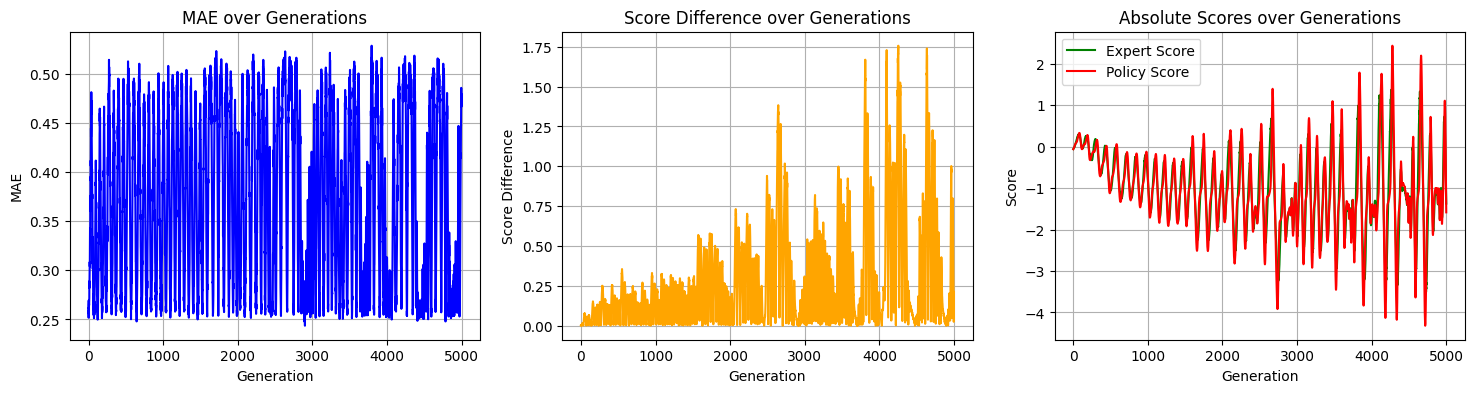

In [ ]:
gens = np.arange(len(maes_list))

fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

axes[0].plot(gens, maes_list, color="blue")
axes[0].set_xlabel("Generation")
axes[0].set_ylabel("MAE")
axes[0].set_title("MAE over Generations")
axes[0].grid(True)

axes[1].plot(gens, score_diffs, color="orange")
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("Score Difference")
axes[1].set_title("Score Difference over Generations")
axes[1].grid(True)

abs_scores_arr = np.array(abs_scores)  # shape: [G, 2]
axes[2].plot(gens, abs_scores_arr[:, 0], color="green", label="Expert Score")
axes[2].plot(gens, abs_scores_arr[:, 1], color="red",  label="Policy Score")
axes[2].set_xlabel("Generation")
axes[2].set_ylabel("Score")
axes[2].set_title("Absolute Scores over Generations")
axes[2].grid(True)
axes[2].legend()